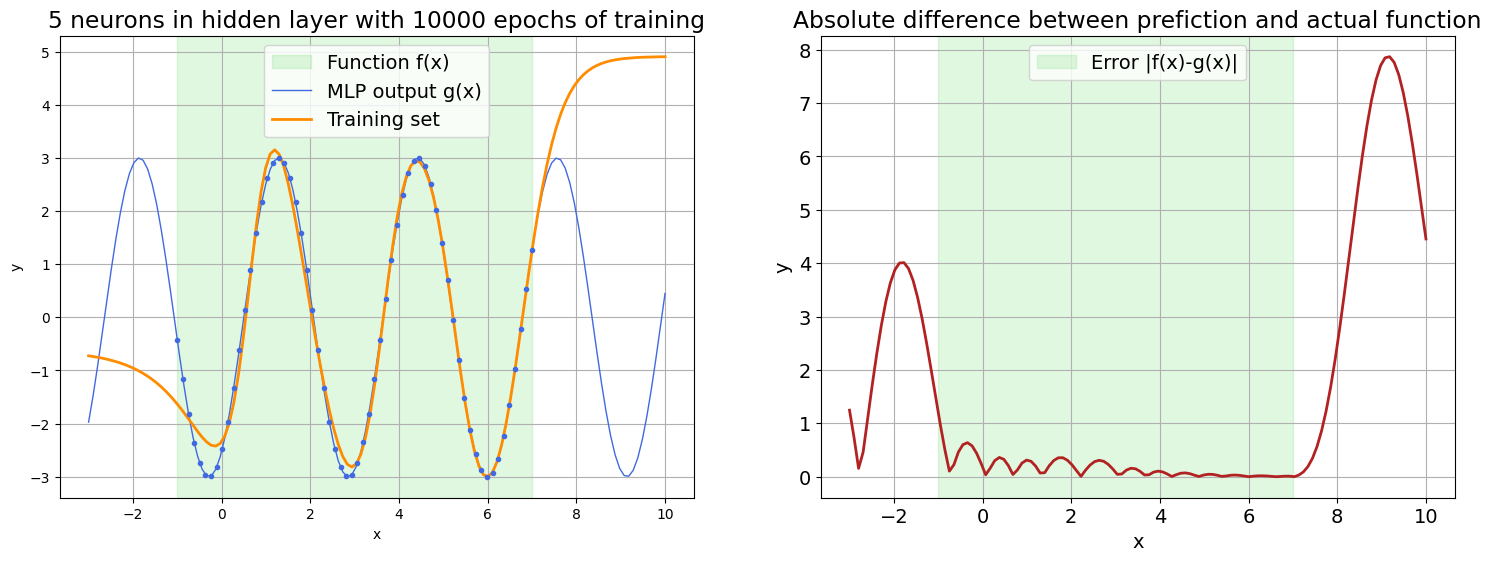

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

activation_function = nn.Tanh()

def myfun(x):
    return 3*np.sin(2*x-1)

def approx_1d_function(x_train, x_eval, units, epochs):
    #Generate labels for training data
    y_train = myfun(x_train)
    #Scale the train data for normalisation
    x_scaler = MinMaxScaler(feature_range=((-1,1)))
    y_scaler = MinMaxScaler(feature_range=((-1,1)))
                            
    x_scaled = x_scaler.fit_transform(x_train)
    y_scaled = y_scaler.fit_transform(y_train)                            
    x_eval_scaled = x_scaler.transform(x_eval)

                            
    #Build and apply MLP                        
    _, result_eval = train_model_simple(x_scaled, y_scaled, x_eval_scaled, units, epochs)
                
    #Rescale back to origin range
    res_rescaled = y_scaler.inverse_transform(result_eval)

    #Calculate the label
    y_eval = myfun(x_eval)
    return x_eval, res_rescaled, y_eval


def train_model_simple(x_train, y_train, x_eval, units, epochs):
    x_train_tensor = torch.from_numpy(x_train).float().to(device)
    x_eval_tensor = torch.from_numpy(x_eval).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).float().to(device)
    # predefined linear layers, parameters are input and output neurons
    layer1 = nn.Linear(x_train.shape[1], units).to(device)
    layer2 = nn.Linear(units, 1).to(device)
    
    #gather parameters for both layers
    parameters = list(layer1.parameters()) + list(layer2.parameters())
    
    #Adam optimiser and MSE Loss
    optimizer = optim.Adam(parameters)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop
    for epoch in range(epochs):
        yhat = layer2(activation_function(layer1(x_train_tensor)))

        loss = loss_fn(yhat, y_train_tensor)

        #compute gradients
        loss.backward()

        #carry out one optimisation step
        optimizer.step()
        
        #rest gradients to zero
        optimizer.zero_grad()
        
    yhat_eval = layer2(activation_function(layer1(x_eval_tensor)))
    
    return yhat.detach().cpu().numpy(), yhat_eval.detach().cpu().numpy()


def plot_1d_function(x_train, x_eval, predictions, labels, units, epochs):
    fig = plt.figure(1, figsize=(18,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
    plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
    plt.plot(x_train, myfun(x_train), '.', color='royalblue')
    plt.grid(which='both')
    plt.rcParams.update({'font.size':14})
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('%d neurons in hidden layer with %d epochs of training' % (units, epochs))
    plt.legend(['Function f(x)', 'MLP output g(x)', 'Training set'])
    ax = fig.add_subplot(1, 2, 2)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, np.abs(predictions-myfun(x_eval)), '-', label='output', color='firebrick', linewidth=2.0)
    plt.grid(which='both')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Absolute difference between prefiction and actual function')
    plt.legend(['Error |f(x)-g(x)|'])
    plt.show()

batch_size_train = 64
batch_size_eval = 128

#Generate train data
x_train_fix = np.linspace(-1, 7, num=batch_size_train).reshape(-1,1)

#Generate eval data
x_eval_fix = np.linspace(-3, 10, num=batch_size_eval).reshape(-1,1)

units = 5
epochs = 10000

x, predictions, labels = approx_1d_function(x_train=x_train_fix, x_eval=x_eval_fix, units=units, epochs=epochs)
plot_1d_function(x_train_fix, x_eval_fix, predictions, labels, units, epochs)



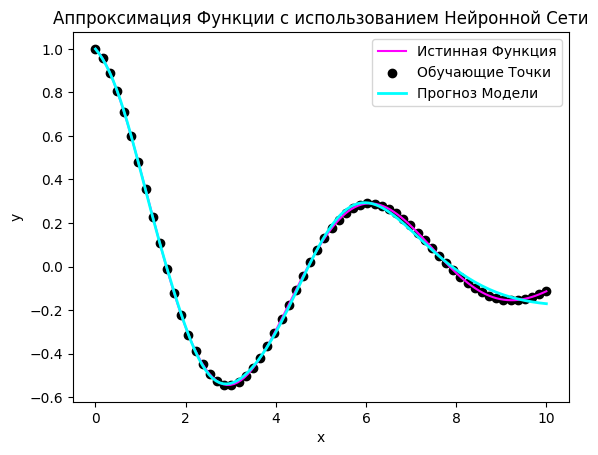

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Определение функции активации
activation_function = nn.Tanh()

# Новая целевая функция
def target_function(x):
    return np.cos(x) * np.exp(-x / 5)

# Генерация обучающих данных
batch_size_train = 64
batch_size_eval = 128

x_train = np.linspace(0, 10, num=batch_size_train).reshape(-1, 1)
y_train = target_function(x_train)

# Генерация тестовых данных
x_test = np.linspace(0, 10, num=batch_size_eval).reshape(-1, 1)
y_test = target_function(x_test)

# Определение функций модели и обучения
def train_model(x_train, y_train, x_test, units, epochs):
    x_train_tensor = torch.from_numpy(x_train).float().to(device)
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).float().to(device)

    layer1 = nn.Linear(x_train.shape[1], units).to(device)
    layer2 = nn.Linear(units, 1).to(device)
    parameters = list(layer1.parameters()) + list(layer2.parameters())
    optimizer = optim.Adam(parameters)
    loss_fn = nn.MSELoss(reduction='mean')

    for epoch in range(epochs):
        yhat = layer2(activation_function(layer1(x_train_tensor)))
        loss = loss_fn(yhat, y_train_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    yhat_test = layer2(activation_function(layer1(x_test_tensor)))
    return yhat_test.detach().cpu().numpy()

# Обучение модели
units = 10
epochs = 10000
predictions = train_model(x_train, y_train, x_test, units, epochs)

# Визуализация результатов
plt.plot(x_test, y_test, label='Истинная Функция', color='magenta')
plt.scatter(x_train, y_train, label='Обучающие Точки', color='black', zorder=1)
plt.plot(x_test, predictions, label='Прогноз Модели', color='cyan', linewidth=2.0, zorder=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Аппроксимация Функции с использованием Нейронной Сети')
plt.legend()
plt.show()
